In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# print(dir(__builtins__))

In [4]:
# import tensorflow as tf
# print("GPU Available:", tf.config.list_physical_devices('GPU'))

In [5]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print('Memory growth enabled')
except:
    pass

Memory growth enabled


In [6]:
import gdown

In [ ]:
url = "https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL"
output = "data.zip"
gdown.download(url, output, quiet=False)
gdown.extractall("data.zip")

In [7]:
def load_video(path: str) -> List[float]:
    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()
    # print(f"Shape of frames: {frames.shape}")
    frames = tf.cast(frames, tf.float32)
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(frames)
    return (frames - mean) / std

    # std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    # return tf.cast((frames - mean), tf.float32) / std

In [8]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [9]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token='')
num_to_char = tf.keras.layers.StringLookup(
                vocabulary=char_to_num.get_vocabulary(), oov_token='', invert=True)
print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [10]:
def load_alignments(path: str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens,' ', line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [44]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    #file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    # print(f"Loading video from: {video_path}")
    # print(f"Loading alignments from: {alignment_path}")
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [45]:
test_path = '.\\data\\s1\\bbal6n.mpg'

In [46]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]

'bbal6n'

In [47]:
frames, alignmentes = load_data(tf.convert_to_tensor(test_path))

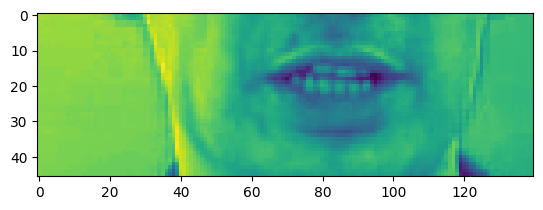

In [48]:
plt.imshow(frames[40])

In [49]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignmentes.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [50]:
def mappable_function(path):
    return tf.py_function(load_data, [path], (tf.float32, tf.int64))

# PIPELINE

In [51]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)

In [70]:
frames, alignments = data.as_numpy_iterator().next()

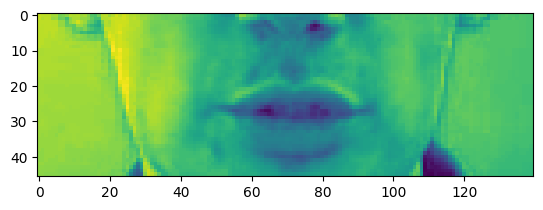

In [71]:
plt.imshow(frames[0][40])

In [72]:
alignments

array([[16, 12,  1,  3,  5, 39, 23,  8,  9, 20,  5, 39, 23,  9, 20,  8,
        39, 25, 39, 20, 23, 15, 39, 14, 15, 23,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [19,  5, 20, 39,  7, 18,  5,  5, 14, 39,  9, 14, 39,  3, 39, 26,
         5, 18, 15, 39, 16, 12,  5,  1, 19,  5,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0]], dtype=int64)

In [76]:
test = data.as_numpy_iterator()
val = test.next()

In [86]:
# Convert the array to uint8 type and remove the extra dimension
frames_uint8 = (val[0][0] * 255).astype(np.uint8)
frames_uint8 = np.squeeze(frames_uint8, axis=-1)
imageio.mimsave('./animation.gif', frames_uint8, fps=10)

In [107]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'lay red at r two please'>